In [1]:
from numpy import *
import os
from pylab import *
import numpy as np
from tensorflow.python.ops import nn_ops
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import time
from scipy.misc import imread
from scipy.misc import imresize
import matplotlib.image as mpimg
from scipy.ndimage import filters
import urllib
from numpy import random


import tensorflow as tf

from caffe_classes import class_names

train_x = zeros((1, 227,227,3)).astype(float32)
train_y = zeros((1, 1000))
xdim = train_x.shape[1:]
ydim = train_y.shape[1]

In [2]:
im1 = (imread("laska.png")[:,:,:3]).astype(float32)
im1 = im1 - mean(im1)
im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]

im2 = (imread("poodle.png")[:,:,:3]).astype(float32)
im2[:, :, 0], im2[:, :, 2] = im2[:, :, 2], im2[:, :, 0]

/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


In [3]:
net_data = load(open("bvlc_alexnet.npy", "rb"), encoding="latin1").item()

In [4]:
def conv(input, kernel, biases, k_h, k_w, c_o, s_h, s_w,  padding="VALID", group=1):
    '''From https://github.com/ethereon/caffe-tensorflow
    '''
    c_i = input.get_shape()[-1]
    assert c_i%group==0
    assert c_o%group==0
    convolve = lambda i, k: tf.nn.conv2d(i, k, [1, s_h, s_w, 1], padding=padding)
    
    
    if group==1:
        conv = convolve(input, kernel)
    else:
        #tf.split(value, num_or_size_splits, axis) -- new version
        ## tf.split(axis, num_or_size_splits, value) -- old version
        
        #input_groups = tf.split(3, group, input)
        #kernel_groups = tf.split(3, group, kernel)
        
        input_groups = tf.split(input, group, 3)
        kernel_groups = tf.split(kernel, group, 3)
        
        output_groups = [convolve(i, k) for i,k in zip(input_groups, kernel_groups)]
        conv = tf.concat( output_groups, 3)
    return  tf.reshape(tf.nn.bias_add(conv, biases), [-1]+conv.get_shape().as_list()[1:])



x = tf.placeholder(tf.float32, (None,) + xdim)

In [5]:
k_h = 11; k_w = 11; c_o = 96; s_h = 4; s_w = 4
conv1W = tf.Variable(net_data["conv1"][0])
conv1b = tf.Variable(net_data["conv1"][1])
conv1_in = conv(x, conv1W, conv1b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=1)
conv1 = tf.nn.relu(conv1_in)

#lrn1
#lrn(2, 2e-05, 0.75, name='norm1')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn1 = tf.nn.local_response_normalization(conv1,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool1
#max_pool(3, 3, 2, 2, padding='VALID', name='pool1')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool1 = tf.nn.max_pool(lrn1, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)


#conv2
#conv(5, 5, 256, 1, 1, group=2, name='conv2')
k_h = 5; k_w = 5; c_o = 256; s_h = 1; s_w = 1; group = 2
conv2W = tf.Variable(net_data["conv2"][0])
conv2b = tf.Variable(net_data["conv2"][1])
conv2_in = conv(maxpool1, conv2W, conv2b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv2 = tf.nn.relu(conv2_in)


#lrn2
#lrn(2, 2e-05, 0.75, name='norm2')
radius = 2; alpha = 2e-05; beta = 0.75; bias = 1.0
lrn2 = tf.nn.local_response_normalization(conv2,
                                                  depth_radius=radius,
                                                  alpha=alpha,
                                                  beta=beta,
                                                  bias=bias)

#maxpool2
#max_pool(3, 3, 2, 2, padding='VALID', name='pool2')                                                  
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool2 = tf.nn.max_pool(lrn2, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#conv3
#conv(3, 3, 384, 1, 1, name='conv3')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 1
conv3W = tf.Variable(net_data["conv3"][0])
conv3b = tf.Variable(net_data["conv3"][1])
conv3_in = conv(maxpool2, conv3W, conv3b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv3 = tf.nn.relu(conv3_in)

#conv4
#conv(3, 3, 384, 1, 1, group=2, name='conv4')
k_h = 3; k_w = 3; c_o = 384; s_h = 1; s_w = 1; group = 2
conv4W = tf.Variable(net_data["conv4"][0])
conv4b = tf.Variable(net_data["conv4"][1])
conv4_in = conv(conv3, conv4W, conv4b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv4 = tf.nn.relu(conv4_in)


#conv5
#conv(3, 3, 256, 1, 1, group=2, name='conv5')
k_h = 3; k_w = 3; c_o = 256; s_h = 1; s_w = 1; group = 2
conv5W = tf.Variable(net_data["conv5"][0])
conv5b = tf.Variable(net_data["conv5"][1])
conv5_in = conv(conv4, conv5W, conv5b, k_h, k_w, c_o, s_h, s_w, padding="SAME", group=group)
conv5 = tf.nn.relu(conv5_in)

#maxpool5
#max_pool(3, 3, 2, 2, padding='VALID', name='pool5')
k_h = 3; k_w = 3; s_h = 2; s_w = 2; padding = 'VALID'
maxpool5 = tf.nn.max_pool(conv5, ksize=[1, k_h, k_w, 1], strides=[1, s_h, s_w, 1], padding=padding)

#fc6
#fc(4096, name='fc6')
fc6W = tf.Variable(net_data["fc6"][0])
fc6b = tf.Variable(net_data["fc6"][1])
fc6 = tf.nn.relu_layer(tf.reshape(maxpool5, [-1, int(prod(maxpool5.get_shape()[1:]))]), fc6W, fc6b)

#fc7
#fc(4096, name='fc7')
fc7W = tf.Variable(net_data["fc7"][0])
fc7b = tf.Variable(net_data["fc7"][1])
fc7 = tf.nn.relu_layer(fc6, fc7W, fc7b)

fc7_xw_plus_b = nn_ops.bias_add(math_ops.matmul(fc6, fc7W), fc7b)


fc7_after_relu = nn_ops.relu(fc7_xw_plus_b)


#fc8
#fc(1000, relu=False, name='fc8')
fc8W = tf.Variable(net_data["fc8"][0])
fc8b = tf.Variable(net_data["fc8"][1])
fc8 = tf.nn.xw_plus_b(fc7, fc8W, fc8b)


#prob
#softmax(name='prob'))
prob = tf.nn.softmax(fc8)

init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

t = time.time()
#output = sess.run(prob, feed_dict = {x:[im1,im2]})
################################################################################

#fc7_xw_plus_b_output = sess.run(fc7_xw_plus_b, feed_dict = {x:[im1,im2]})

#Output:
'''
for input_im_ind in range(output.shape[0]):
    inds = argsort(output)[input_im_ind,:]
    print "Image", input_im_ind
    for i in range(5):
        print class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]]
'''
#print 'two-step ReLu:',fc7_xw_plus_b_output[1,:]





Instructions for updating:
Use `tf.global_variables_initializer` instead.


'\nfor input_im_ind in range(output.shape[0]):\n    inds = argsort(output)[input_im_ind,:]\n    print "Image", input_im_ind\n    for i in range(5):\n        print class_names[inds[-1-i]], output[input_im_ind, inds[-1-i]]\n'

In [15]:
raw_image_list = []
image_list = []
classes = 0  # number of classes
image_nums = 0  # images from each class

for item in os.listdir('tiny-imagenet-200/train/'):
# 	print(item)
	if classes == 200:
		break
	classes += 1
	#print('tiny-imagenet-200/train/'+item)
	for item_2 in os.listdir('tiny-imagenet-200/train/'+item):
		if(item_2 == 'images'):
			image_nums = 0
			for item_3 in os.listdir('tiny-imagenet-200/train/'+item+'/images'):
				try:
					if image_nums == 20:
						break
					image_nums += 1
					image_name = 'tiny-imagenet-200/train/'+item+'/images/'+item_3
					im1 = imread(image_name)
					raw_image_list.append(im1)
					im1 = imresize(im1,(227,227,3))
					im1 = (im1[:,:,:3]).astype(float32)
					im1 = im1 - mean(im1)
					im1[:, :, 0], im1[:, :, 2] = im1[:, :, 2], im1[:, :, 0]
					image_list.append(im1)
				except:
					print('Error')


# print("new_image_list: ", new_image_list)
#new_image_list = np.reshape(image_list,(-1,227,227,3))

/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/Users/mac/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


In [16]:
from IPython.display import display
import matplotlib.pyplot as plt
# taking subset of image for low computation.
new_image_list = image_list

output = sess.run(fc7_xw_plus_b, feed_dict = {x:new_image_list})

print("Images", len(image_list))
print ("output shape:", output.shape)

# pick subset of output to plot.
small_output = output[:,:10]
#small_output = output[:,3818 1349  891 3525 1543 4020  498 2296  365  803]

# visualizing the output indices.
display(small_output.argsort(axis=0))

#soreted image index matrix.
sorted_index_matrix = small_output.argsort(axis=0)

print("Shape of sorted index matrix: ", sorted_index_matrix.shape)

# for i in small_output.argsort(axis=0)[:,0]:
    
#     plt.imshow(raw_image_list[i])
#     plt.show()
    

Images 3935
output shape: (3935, 4096)


array([[2737, 1745, 2451, ..., 1745, 1745, 1545],
       [2316, 3810, 2455, ..., 2329, 2976,  283],
       [2636,  290,  426, ..., 2402, 2636, 2636],
       ..., 
       [2289, 2397, 2309, ..., 1374, 2622,  666],
       [2946, 3492, 1775, ..., 1015, 1115, 1877],
       [2929, 3535, 1570, ...,  493, 1661, 2103]])

Shape of sorted index matrix:  (3935, 10)


shape of grid : 20 10


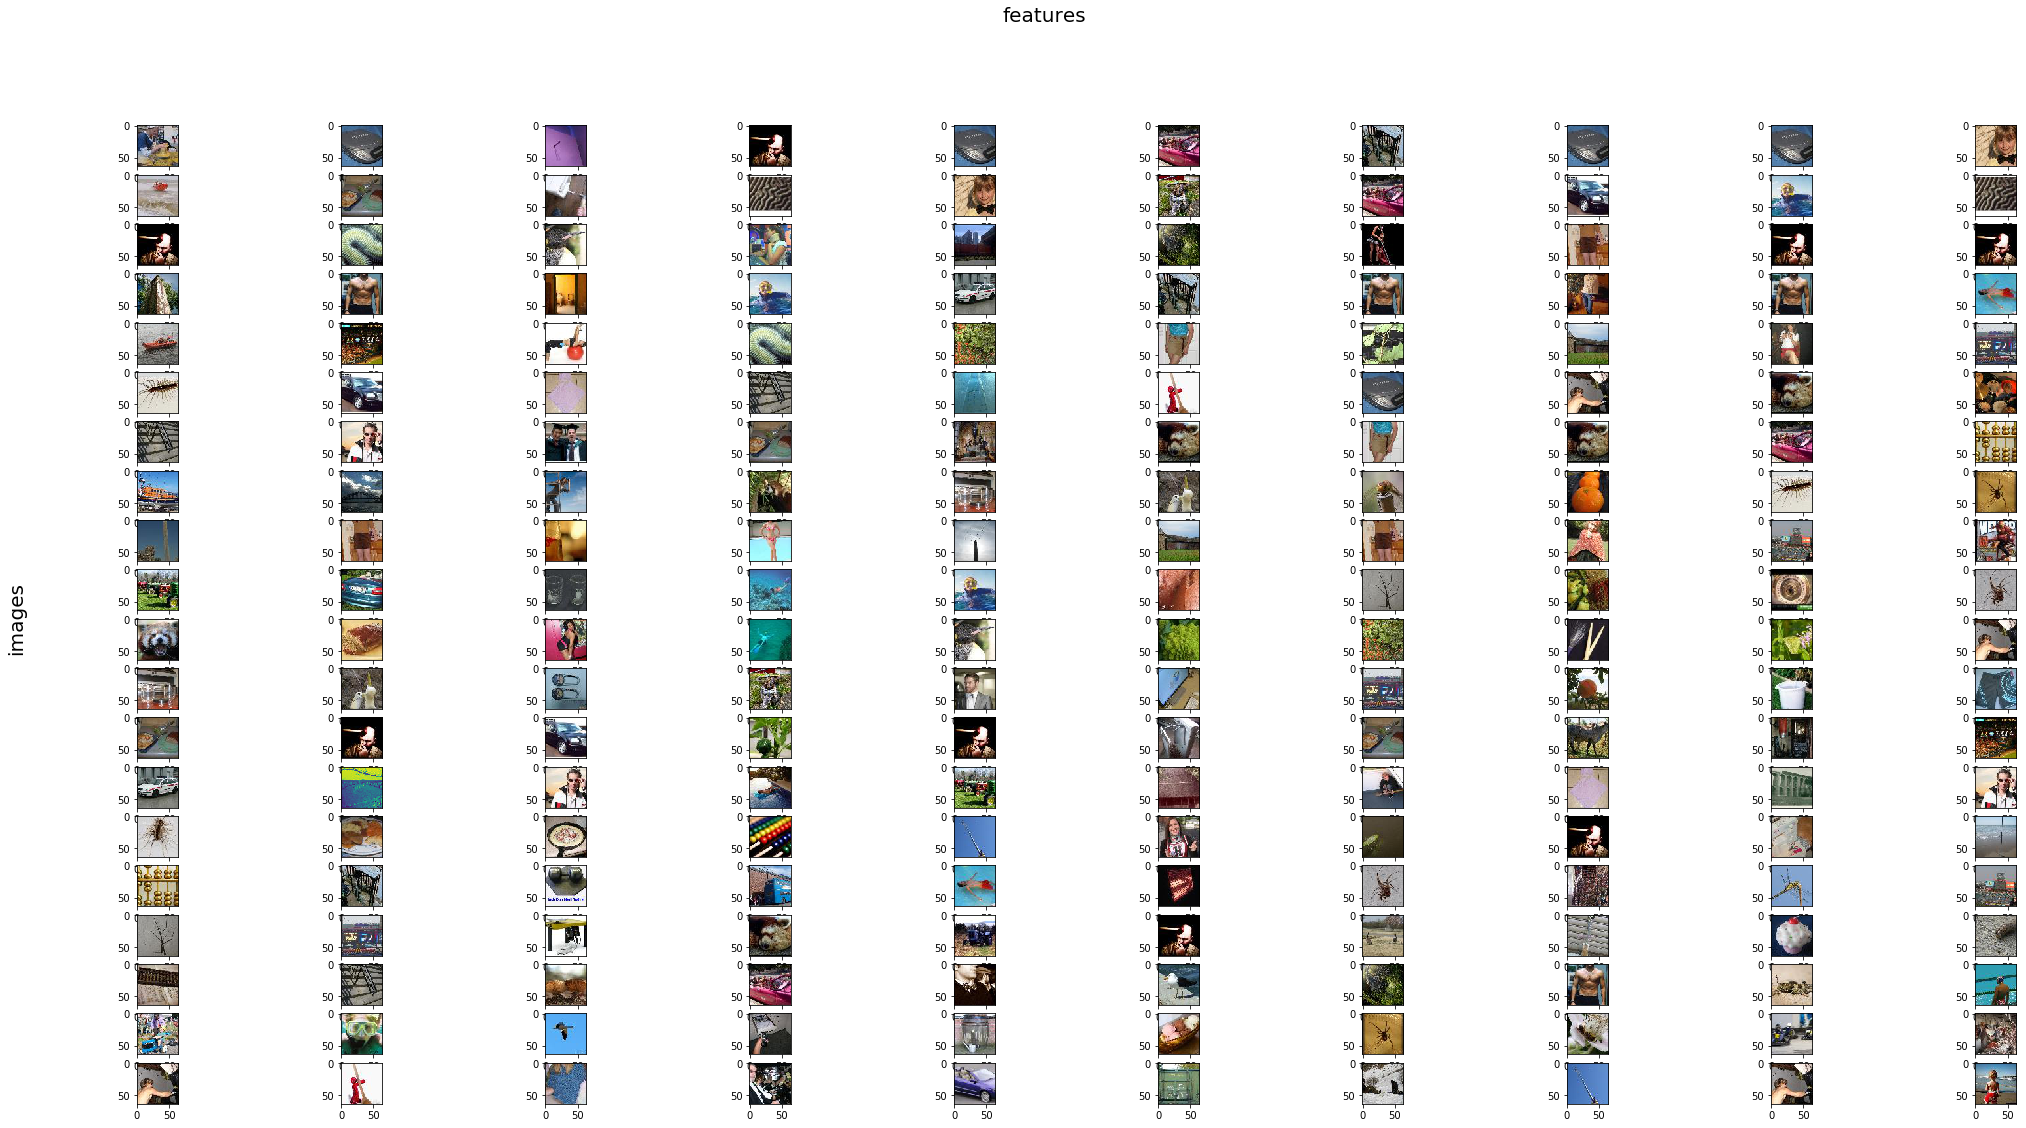

In [17]:

def make_ticklabels_invisible(fig):
    for i, ax in enumerate(fig.axes):
#         ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

fig = plt.figure(figsize=(36,18))

m, n = sorted_index_matrix.shape
print("shape of grid :", min(m, 20) ,n)
gs = GridSpec(min(m, 20), n)

for idx_m in range(min(m, 20)):
    for idx_n in range(n):
        ax = plt.subplot(gs[idx_m, idx_n])
        
        image_idx = sorted_index_matrix[idx_m, idx_n]
        ax.imshow(raw_image_list[image_idx])

#plt.xlabel('features')   
fig.text(0.5,0.96,'features',ha='center', fontsize=20)
fig.text(0.1,0.5, 'images', va='center', fontsize =20, rotation = 'vertical')
plt.show()

make_ticklabels_invisible(fig)
fig.savefig("fc7_visulization")